In [86]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [87]:
#!pip install xgboost

In [88]:
import warnings
warnings.filterwarnings('ignore')
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from copy import deepcopy


In [89]:
x_train = pd.read_csv('https://raw.githubusercontent.com/jjbl99/waterpump/master/xtrain_clean.csv')
y_train = pd.read_csv('https://raw.githubusercontent.com/jjbl99/waterpump/master/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv')
x_test = pd.read_csv('https://raw.githubusercontent.com/jjbl99/waterpump/master/xtest_clean.csv')

In [ ]:
x_test_id = x_test['id']
x_test = x_test.drop('id', axis = 1, inplace = True)

In [93]:
y_train.columns
y_num = y_train.replace(['functional','non functional', 'functional needs repair'], [0,1,2])

In [71]:
# Turn all data types into categorical data types
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): 
            df[n] = pd.factorize(df[n])[0]
    return df

In [72]:
xcat_mean = deepcopy(x_train)
xtest_mean = deepcopy(x_test)

xcat_mean['target'] = deepcopy(y_num)['status_group']
for n,c in x_train.items():
        if is_string_dtype(c): 
            xcat_mean[n] = xcat_mean[n].map(xcat_mean.groupby(c)['target'].mean())
            xtest_mean[n] = xtest_mean[n].map(xcat_mean.groupby(c)['target'].mean()) 
            #DID IT WORK FOR TEST? How to stock the value?

xcat_mean = xcat_mean.drop('target', axis=1)
#display(xcat_mean.head(), xtest_mean.head())

In [84]:
x_train = train_cats(x_train)
x_test = train_cats(x_test)

In [74]:
#y_num = y_train.replace(['functional','non functional', 'functional needs repair'], [0,1,2]) # replace labels by numerical values

In [75]:
x_train.drop('id', axis = 1, inplace = True)
y_train.drop('id', axis = 1, inplace = True)

In [76]:
#xtrain.head()

# Feature Selection

In [77]:
#I ran the feature selection apriori since it's easier to remove things from a panda array than a np matrix 

#x_train.drop(['year_recorded','source_class','date_recordedMonth','public_meeting','basin','payment_type','water_quality'], axis = 1, inplace = True)
#x_test.drop(['year_recorded','source_class','date_recordedMonth','public_meeting','basin','payment_type','water_quality'], axis = 1, inplace = True)

In [78]:
xtrain, xvalid, ytrain, yvalid = train_test_split(x_train, y_num, test_size=0.2)
ytrain.drop('id', axis = 1, inplace = True)
yvalid.drop('id', axis = 1, inplace = True)
xtrain.drop('Unnamed: 0', axis = 1, inplace = True)
xvalid.drop('Unnamed: 0', axis = 1, inplace = True)
scaler = StandardScaler()
feature_list = xtrain.columns

xtrain_FS = xtrain
xvalid_FS = xvalid

xtrain_PCA = xtrain
xvalid_PCA = xvalid

# Fit on training set only.
scaler.fit(xtrain)

# Apply transform to both the training set and the test set.
xtrain = scaler.transform(xtrain)
xvalid = scaler.transform(xvalid)


Training accuracy:  0.982765151515
Validation accuracy:  0.792003367003


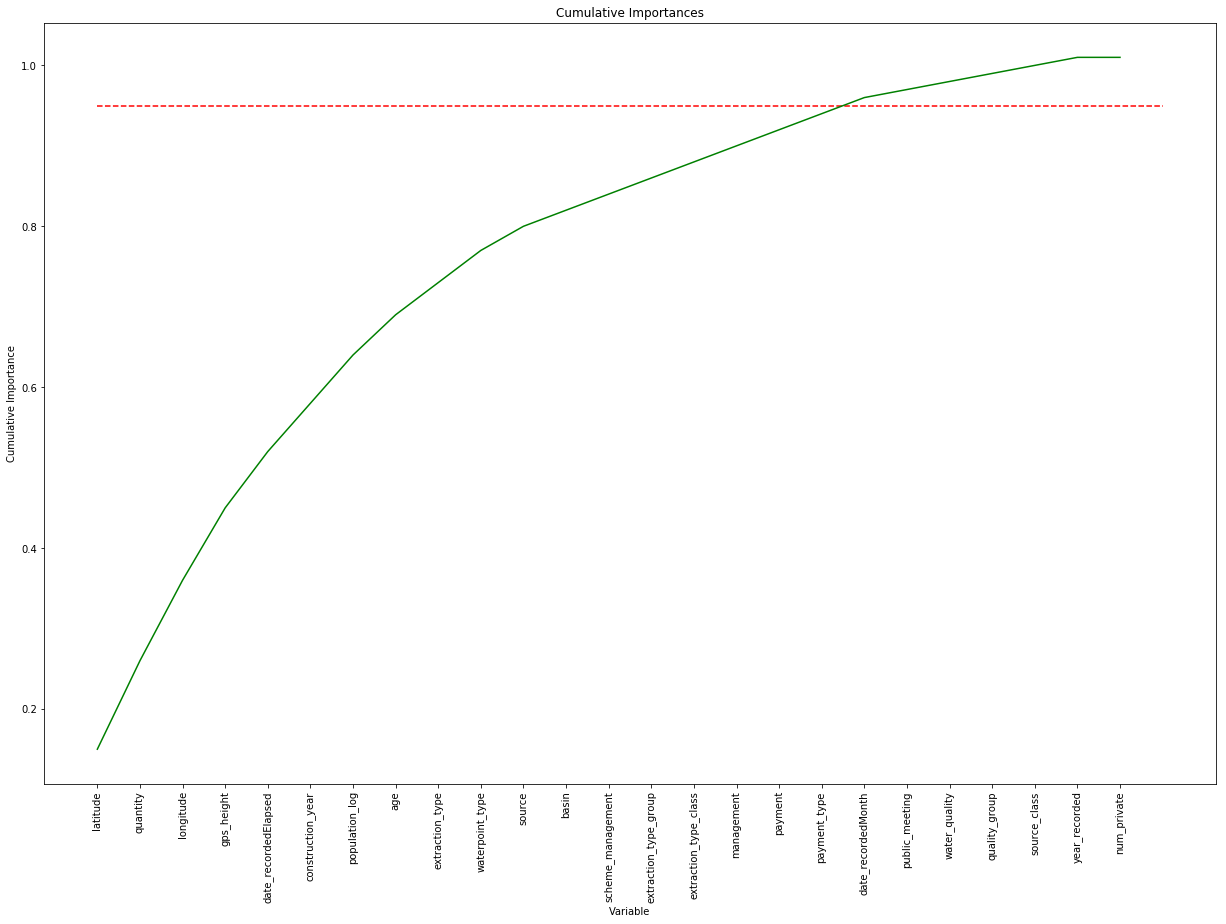

In [79]:
rf = RandomForestClassifier(max_depth=100).fit(xtrain,ytrain)
pred2 = rf.predict(xvalid)

print('Training accuracy: ', accuracy_score(ytrain, rf.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, pred2))
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# list of x locations for plotting
x_values = list(range(len(importances)))

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.figure(figsize=(21,14))
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

plt.show()

#this plot is no longer relevant since its using already reduced features

In [80]:
xvalid_FS.drop(['date_recordedMonth','public_meeting','water_quality','quality_group','source_class','year_recorded','num_private'], axis = 1, inplace = True)
xtrain_FS.drop(['year_recorded','source_class','date_recordedMonth','public_meeting','water_quality','quality_group','num_private'], axis = 1, inplace = True)

# PCA

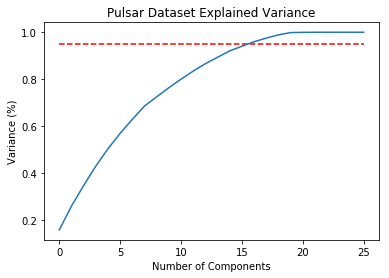

In [155]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(xtrain)

# Apply transform to both the training set and the test set.
#xtrain = scaler.transform(xtrain)
#xvalid = scaler.transform(xvalid)

#Fitting the PCA algorithm with our Data
pca1 = PCA().fit(xtrain)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca1.explained_variance_ratio_))
plt.hlines(y = 0.95, xmin=0, xmax= 25,color = 'r', linestyles = 'dashed')

plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [156]:
#fit model with optimal components (90% variance kept)
pca = PCA(n_components= 15)
pca.fit(xtrain) 

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_)  

xvalid_PCA = pca.transform(xvalid)
xtrain_PCA = pca.transform(xtrain)
#x_test_PCA = pca.transform(x_test)

[ 0.15661033  0.10171181  0.08757045  0.08289238  0.07425123  0.06577702
  0.0596076   0.05682949  0.03931604  0.03870255  0.03653333  0.03449985
  0.03146241  0.02747456  0.02727166]


# Decision Tree Classifier

In [17]:
#with PCA
dtc_PCA = DecisionTreeClassifier(max_depth=5).fit(xtrain_PCA, ytrain)
pred1_PCA = dtc_PCA.predict(xvalid_PCA)

In [18]:
print('Training accuracy: ', accuracy_score(ytrain, dtc_PCA.predict(xtrain_PCA)))
print('Validation accuracy: ', accuracy_score(yvalid, pred1_PCA))

Training accuracy:  0.681102693603
Validation accuracy:  0.671885521886


In [19]:
#with FS
dtc_FS = DecisionTreeClassifier(max_depth=5).fit(xtrain_FS, ytrain)
pred1_FS = dtc_FS.predict(xvalid_FS)

In [20]:
print('Training accuracy: ', accuracy_score(ytrain, dtc_FS.predict(xtrain_FS)))
print('Validation accuracy: ', accuracy_score(yvalid, pred1_FS))

Training accuracy:  0.711195286195
Validation accuracy:  0.700252525253


# Random Forest Classifier

In [21]:
rf_PCA = RandomForestClassifier(max_depth=100).fit(xtrain_PCA,ytrain)
pred2_PCA = rf_PCA.predict(xvalid_PCA)

In [22]:
print('Training accuracy: ', accuracy_score(ytrain, rf_PCA.predict(xtrain_PCA)))
print('Validation accuracy: ', accuracy_score(yvalid, pred2_PCA))

Training accuracy:  0.981334175084
Validation accuracy:  0.757070707071


In [23]:
rf_FS = RandomForestClassifier(max_depth=100).fit(xtrain_FS,ytrain)
pred2_FS = rf_FS.predict(xvalid_FS)

print('Training accuracy: ', accuracy_score(ytrain, rf_FS.predict(xtrain_FS)))
print('Validation accuracy: ', accuracy_score(yvalid, pred2_FS))

Training accuracy:  0.981755050505
Validation accuracy:  0.784764309764


# Support Vector Machine

In [24]:
svm = SVC().fit(xtrain_PCA,ytrain)
pred3 = svm.predict(xvalid_PCA)

In [26]:
print('Training accuracy: ', accuracy_score(ytrain, svm.predict(xtrain_PCA)))
print('Validation accuracy: ', accuracy_score(yvalid, pred3))

Training accuracy:  0.759301346801
Validation accuracy:  0.73367003367


In [27]:
svm = SVC().fit(xtrain_FS,ytrain)
pred3 = svm.predict(xvalid_FS)

In [29]:
print('Training accuracy: ', accuracy_score(ytrain, svm.predict(xtrain_FS)))
print('Validation accuracy: ', accuracy_score(yvalid, pred3))

Training accuracy:  0.918434343434
Validation accuracy:  0.676515151515


# SGD

In [34]:
xtrain, xvalid = xtrain_FS, xvalid_FS

In [35]:
sgd = SGDClassifier(loss="hinge", penalty="l2").fit(xtrain,ytrain)
pred4 = sgd.predict(xvalid)

In [36]:
print('Training accuracy: ', accuracy_score(ytrain, sgd.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, pred4))

Training accuracy:  0.572306397306
Validation accuracy:  0.567255892256


In [37]:
xtrain, xvalid = xtrain_PCA, xvalid_PCA

In [38]:
sgd = SGDClassifier(loss="hinge", penalty="l2").fit(xtrain,ytrain)
pred4 = sgd.predict(xvalid)

In [39]:
print('Training accuracy: ', accuracy_score(ytrain, sgd.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, pred4))

Training accuracy:  0.60281986532
Validation accuracy:  0.598400673401


# KNN

In [40]:
xtrain, xvalid = xtrain_FS, xvalid_FS

In [41]:
knn = KNeighborsClassifier(n_neighbors=7).fit(xtrain,ytrain)
pred5 = knn.predict(xvalid)

In [42]:
print('Training accuracy: ', accuracy_score(ytrain, knn.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, pred5))

Training accuracy:  0.752272727273
Validation accuracy:  0.67803030303


In [43]:
xtrain, xvalid = xtrain_PCA, xvalid_PCA

In [44]:
knn = KNeighborsClassifier(n_neighbors=7).fit(xtrain,ytrain)
pred5 = knn.predict(xvalid)

In [45]:
print('Training accuracy: ', accuracy_score(ytrain, knn.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, pred5))

Training accuracy:  0.811868686869
Validation accuracy:  0.754966329966


# Naive Bayes

In [46]:
xtrain, xvalid = xtrain_FS, xvalid_FS

In [47]:
gnb = GaussianNB().fit(xtrain,ytrain)
pred6 = gnb.predict(xvalid)

In [48]:
print('Training accuracy: ', accuracy_score(ytrain, gnb.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, pred6))

Training accuracy:  0.610353535354
Validation accuracy:  0.610858585859


In [49]:
xtrain, xvalid = xtrain_PCA, xvalid_PCA

In [50]:
gnb = GaussianNB().fit(xtrain,ytrain)
pred6 = gnb.predict(xvalid)

In [51]:
print('Training accuracy: ', accuracy_score(ytrain, gnb.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, pred6))

Training accuracy:  0.623800505051
Validation accuracy:  0.61835016835


# Neural Network

In [52]:
xtrain, xvalid = xtrain_FS, xvalid_FS

In [53]:
mlp = MLPClassifier().fit(xtrain,ytrain)
pred7 = mlp.predict(xvalid)

In [54]:
print('Training accuracy: ', accuracy_score(ytrain, mlp.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, pred7))

Training accuracy:  0.546506734007
Validation accuracy:  0.540656565657


In [55]:
xtrain, xvalid = xtrain_PCA, xvalid_PCA

In [56]:
mlp = MLPClassifier().fit(xtrain,ytrain)
pred7 = mlp.predict(xvalid)

In [57]:
print('Training accuracy: ', accuracy_score(ytrain, mlp.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, pred7))

Training accuracy:  0.761784511785
Validation accuracy:  0.737121212121


# Optimizing the Random Forest

In [ ]:
param_grid = { 
    'n_estimators': [300, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,10,30,50],
    'criterion' :['gini', 'entropy']
}

In [ ]:
gridRF = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 5)
gridRF.fit(xtrain, ytrain)

In [ ]:
gridRF.best_params_

In [ ]:
rf1 = RandomForestClassifier(max_depth=30, criterion = 'gini', max_features='sqrt', n_estimators=500).fit(xtrain,ytrain)
predrf1 = rf1.predict(xvalid)

In [ ]:
print('Training accuracy: ', accuracy_score(ytrain, rf1.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, predrf1))

In [ ]:
rf2 = RandomForestClassifier(max_depth=30, criterion = 'gini', max_features='sqrt', n_estimators=700).fit(xtrain,ytrain)
predrf2 = rf2.predict(xvalid)
print('Training accuracy: ', accuracy_score(ytrain, rf2.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, predrf2))


In [ ]:
rf3 = RandomForestClassifier(n_estimators=300, 
                                min_samples_split=8,
                                max_features='sqrt',
                                max_depth=95)
rf3.fit(xtrain,ytrain)
trainrf3 = rf3.predict(xtrain)
predrf3 = rf3.predict(xvalid)
print('Training accuracy: ', accuracy_score(ytrain, trainrf3))
print('Validation accuracy: ', accuracy_score(yvalid, predrf3))

# Extremely Randomized Trees

In [157]:
xtrain, xvalid = xtrain_FS, xvalid_FS
etc = ExtraTreesClassifier(n_estimators=300, 
                                min_samples_split=8,
                                max_features='sqrt',
                                max_depth=95)
etc.fit(xtrain,ytrain)
predetc = etc.predict(xvalid)


In [158]:
print('Training accuracy: ', accuracy_score(ytrain, etc.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, predetc))

Training accuracy:  1.0
Validation accuracy:  1.0


# XGBoost

In [ ]:
xtrain, xvalid = xtrain_PCA, xvalid_PCA
#TODO perform grid search to find best hyperparameters (this has potential)
xgb = XGBClassifier(max_depth=9, n_estimators=300,
       objective='multi:softmax') #can also use softprob for multiclass
xgb.fit(xtrain,ytrain)
trainxgb = xgb.predict(xtrain)
predxgb = xgb.predict(xvalid)

In [ ]:
#ytrain.drop('id', axis = 1, inplace = True)
#yvalid.drop('id', axis = 1, inplace = True)

In [ ]:
print('Training accuracy: ', accuracy_score(ytrain, trainxgb))
print('Validation accuracy: ', accuracy_score(yvalid, predxgb))

In [ ]:
xtrain, xvalid = xtrain_FS, xvalid_FS
#TODO perform grid search to find best hyperparameters (this has potential)
xgb = XGBClassifier(max_depth=9, n_estimators=300,
       objective='multi:softmax') #can also use softprob for multiclass
xgb.fit(xtrain,ytrain)
trainxgb = xgb.predict(xtrain)
predxgb = xgb.predict(xvalid)
print('Training accuracy: ', accuracy_score(ytrain, trainxgb))
print('Validation accuracy: ', accuracy_score(yvalid, predxgb))

# XG Boost parameter tuning

In [ ]:
xtrain, xvalid = xtrain_FS, xvalid_FS

In [ ]:
param_test1 = {
 'max_depth':range(3,10,3),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(xtrain, ytrain.values.ravel())
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
rf1 = RandomForestClassifier(max_depth=30, criterion = 'gini', max_features='sqrt', n_estimators=500).fit(xtrain,ytrain)
predrf1 = rf1.predict(xvalid)

In [ ]:
print('Training accuracy: ', accuracy_score(ytrain, rf1.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, predrf1))

In [ ]:
rf2 = RandomForestClassifier(max_depth=30, criterion = 'gini', max_features='sqrt', n_estimators=700).fit(xtrain,ytrain)
predrf2 = rf2.predict(xvalid)
print('Training accuracy: ', accuracy_score(ytrain, rf2.predict(xtrain)))
print('Validation accuracy: ', accuracy_score(yvalid, predrf2))


In [ ]:
rf3 = RandomForestClassifier(n_estimators=300, 
                                min_samples_split=8,
                                max_features='sqrt',
                                max_depth=95)
rf3.fit(xtrain,ytrain)
trainrf3 = rf3.predict(xtrain)
predrf3 = rf3.predict(xvalid)
print('Training accuracy: ', accuracy_score(ytrain, trainrf3))
print('Validation accuracy: ', accuracy_score(yvalid, predrf3))

# Stacking our best two models

TODO: code own stacker thing
plot correlation of two models (more uncorrelated is better askip)

In [ ]:
stacker = LogisticRegression()
twotrain = pd.concat([pd.Series(trainrf3),pd.Series(trainxgb)], axis = 1)
twopred = pd.concat([pd.Series(predrf3),pd.Series(predxgb)], axis = 1)

stacker.fit(twotrain, ytrain)

In [ ]:
stackerpred = stacker.predict(twopred)

In [ ]:
print('Training accuracy: ', accuracy_score(ytrain, stacker.predict(twotrain)))
print('Validation accuracy: ', accuracy_score(yvalid, stackerpred))

In [ ]:
cm = confusion_matrix(predrf3,yvalid)

In [ ]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print(cm)

In [ ]:
cm2 = confusion_matrix(predxgb,yvalid)

In [ ]:
print(cm2)

In [ ]:
twotrain.corr()

In [ ]:
twopred.corr()